# Домашнее задание: Обучение и визуализация Mamba

Цель задания

Обучить простую модель семейства Mamba для обработки любых данных (на выбор: текст, аудио, видео, изображения и ...)
Визуализировать веса внимания и интерпретировать их
Сделать выводы о том, как модель воспринимает данные и принимает решения

In [11]:
! pip install torch torchvision torchaudio datasets tqdm --quiet

In [20]:
import math, re, random, collections
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

device = "cpu"
SEED = 42
BATCH_SIZE = 64
LR = 3e-4
EMB_DIM = 128
STATE_DIM = 64
MAX_LEN = 128
random.seed(SEED)
torch.manual_seed(SEED)

In [21]:
RAW_TRAIN = load_dataset("ag_news", split="train[:5000]")
RAW_TEST = load_dataset("ag_news", split="test[:1000]")


def basic_tokenizer(text):
    # простейшая токенизация: слова и цифры
    return re.findall(r"[A-Za-z]+|[0-9]+", text.lower())


# строим словарь
counter = collections.Counter(tok for ex in RAW_TRAIN["text"]
                              for tok in basic_tokenizer(ex))
itos = ["<pad>", "<unk>"] + [t for t, c in counter.items() if c >= 3]
stoi = {t: i for i, t in enumerate(itos)}


def encode(text):
    return [stoi.get(tok, stoi["<unk>"]) for tok in basic_tokenizer(text)][:MAX_LEN]


class NewsDataset(Dataset):
    def __init__(self, ds):
        self.data = [(encode(t), l) for t, l in zip(ds["text"], ds["label"])]

    def __len__(self): return len(self.data)

    def __getitem__(self, idx): return self.data[idx]


def collate(batch):
    seqs, labels = zip(*batch)
    l = [len(s) for s in seqs]
    padded = [s + [0] * (MAX_LEN - len(s)) for s in seqs]
    return torch.tensor(padded, dtype=torch.long), torch.tensor(labels)


train_loader = DataLoader(NewsDataset(RAW_TRAIN), BATCH_SIZE,
                          shuffle=True, collate_fn=collate)
test_loader = DataLoader(NewsDataset(RAW_TEST), BATCH_SIZE,
                         shuffle=False, collate_fn=collate)

print(f"Vocab size: {len(itos)}")

Vocab size: 7230


In [22]:
class SimpleMambaBlock(nn.Module):
    def __init__(self, d_model, d_state):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.in_proj = nn.Linear(d_model, d_state * 2)
        self.w = nn.Parameter(torch.randn(d_state))  # затухание
        self.out_proj = nn.Linear(d_state, d_model)

    def forward(self, x, return_gates=False):
        h = self.norm(x)
        u, v = self.in_proj(h).chunk(2, dim=-1)  # [B,L,S] each
        sigma_w = torch.sigmoid(self.w)  # [S]
        s = torch.zeros(x.size(0), STATE_DIM, device=x.device)
        outs, gates = [], []
        for t in range(x.size(1)):
            s = s * sigma_w + u[:, t]  # обновили скрытое состояние
            g = torch.sigmoid(v[:, t])  # gate-вектор размер S
            gates.append(g.detach())  # для визуализации
            outs.append(self.out_proj(s * g))
        y = torch.stack(outs, dim=1)  # [B,L,D]
        if return_gates:
            return x + y, torch.stack(gates, dim=1)
        return x + y


In [23]:
class MambaClassifier(nn.Module):
    def __init__(self, vocab, num_classes):
        super().__init__()
        self.emb = nn.Embedding(vocab, EMB_DIM)
        self.pos = nn.Parameter(torch.randn(MAX_LEN, EMB_DIM))
        self.m1 = SimpleMambaBlock(EMB_DIM, STATE_DIM)
        self.m2 = SimpleMambaBlock(EMB_DIM, STATE_DIM)
        self.head = nn.Linear(EMB_DIM, num_classes)

    def forward(self, x, return_gates=False):
        h = self.emb(x) + self.pos[:x.size(1)]
        h, g1 = self.m1(h, return_gates=True)  # берём g1 для визуализации
        h = self.m2(h)
        # сферическое усреднение по токенам
        h = h.mean(dim=1)
        if return_gates:
            return self.head(h), g1  # [B,C] , [B,L,S]
        return self.head(h)


model = MambaClassifier(len(itos), 4).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
print("Параметров всего:", sum(p.numel() for p in model.parameters()) // 1_000, "K")

Параметров всего: 992 K


In [25]:
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    model.train();
    total = correct = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad();
        loss.backward();
        optimizer.step()
        total += y.size(0)
        correct += (logits.argmax(-1) == y).sum().item()
    print(f"Epoch {epoch}")
    print(f"  train acc: {correct / total:.3f}")
    # простая валидация
    model.eval();
    total = correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            total += y.size(0)
            correct += (logits.argmax(-1) == y).sum().item()
    print(f"  test  acc: {correct / total:.3f}")

Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1
  train acc: 0.842
  test  acc: 0.734


Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2
  train acc: 0.848
  test  acc: 0.726


Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3
  train acc: 0.866
  test  acc: 0.729


Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4
  train acc: 0.882
  test  acc: 0.720


Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5
  train acc: 0.890
  test  acc: 0.744


Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6
  train acc: 0.907
  test  acc: 0.743


Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7
  train acc: 0.914
  test  acc: 0.754


Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8
  train acc: 0.919
  test  acc: 0.757


Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9
  train acc: 0.934
  test  acc: 0.744


Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10
  train acc: 0.942
  test  acc: 0.755


Судя по результатам, модель переобучается, тк она всё лучше запоминает train, но её способность обобщать на test растёт медленнее. Скорее всего, это происходит, потому что используется не весь датасет (использую небольшую часть датасета, чтобы обучилось быстрее).
В целом результаты неплохие, можно улучшить, если взять больше данных + можно добавить dropout (те усложнить модель).

────────────────────────────────────────────────────────────────────────────────────────────────────
Новость:
Oil Prices Alter Direction After a month-long rally that repeatedly pushed prices to new highs, the cost of a barrel slumped for the fourth day, leaving the price \$10 higher than year-ago rate.

Истинный класс: Business (2)
Предсказанный  : Business (2)


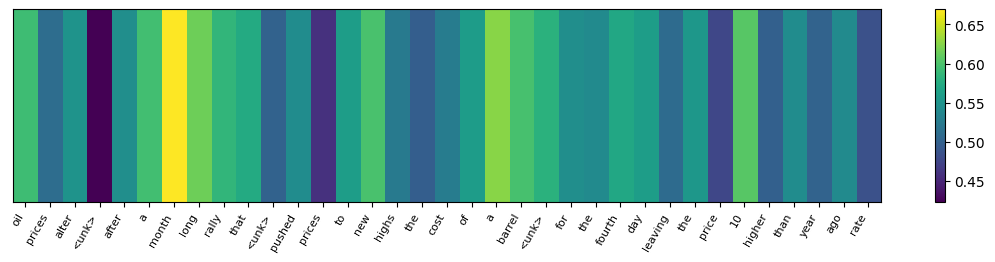

────────────────────────────────────────────────────────────────────────────────────────────────────
Новость:
Badminton pair want more Nathan Robertson says there is no reason why he and badminton partner Gail Emms should not win the next Olympics.

Истинный класс: Sports (1)
Предсказанный  : Sports (1)


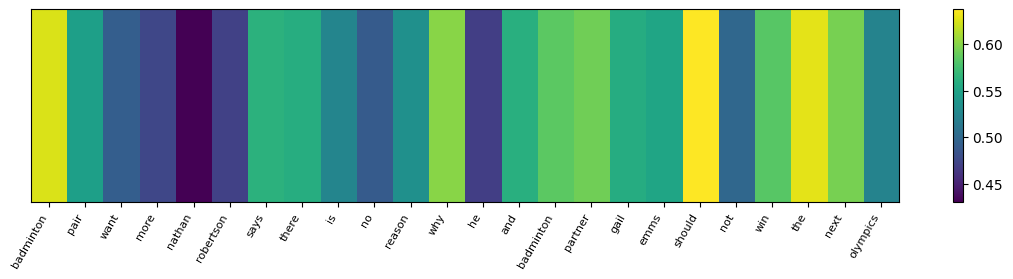

────────────────────────────────────────────────────────────────────────────────────────────────────
Новость:
Five facts about France #39;s Muslim headscarf ban - The French parliament passed the law in March to ban  quot;conspicuous symbols quot; of faith from its state school system. Guidelines for applying the law identified Muslim headscarves, Jewish skullcaps and large 

Истинный класс: World (0)
Предсказанный  : World (0)


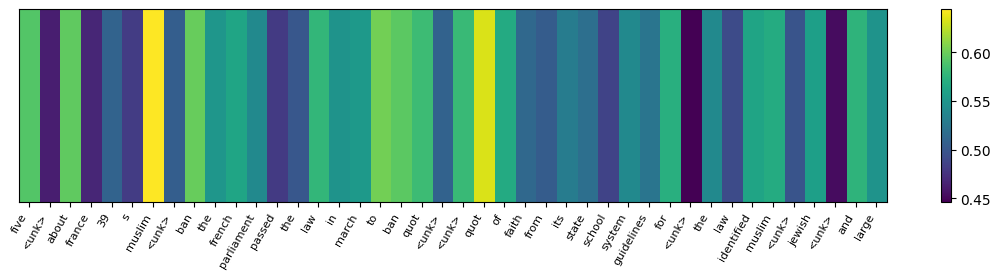

In [42]:
import random, matplotlib.pyplot as plt

LABEL_NAMES = RAW_TRAIN.features["label"].names  # ['World', 'Sports', 'Business', 'Sci/Tech']


def show_attention(sent=None, idx=None, max_len=MAX_LEN):
    if sent is None:
        if idx is None:
            idx = random.randint(0, len(RAW_TEST) - 1)
        sent = RAW_TEST[idx]["text"]
        true_idx = RAW_TEST[idx]["label"]
        true_label = LABEL_NAMES[true_idx]
    else:
        true_label = None

    tok_ids = encode(sent)
    L = len(tok_ids)
    padded = tok_ids + [0] * (max_len - L)  # pad до MAX_LEN
    x = torch.tensor(padded, dtype=torch.long, device=device).unsqueeze(0)  # [1,L]

    with torch.no_grad():
        logits, gates = model(x, return_gates=True)  # gates: [1,L,S]
    importance = gates.squeeze(0).mean(-1)[:L].cpu()  # усредняем по S, берём первую L

    tokens = [itos[i] for i in tok_ids]
    pred_idx = logits.argmax(-1).item()
    pred_label = LABEL_NAMES[pred_idx]

    print("─" * 100)
    print("Новость:")
    print(sent.replace("\n", " "))
    print()
    if true_label is not None:
        print(f"Истинный класс: {true_label} ({true_idx})")
    print(f"Предсказанный  : {pred_label} ({pred_idx})")

    plt.figure(figsize=(min(14, 0.6 * L), 2.5))
    plt.imshow(importance.unsqueeze(0), aspect="auto")
    plt.yticks([])
    plt.xticks(range(L), tokens, rotation=60, ha="right", fontsize=8)
    plt.colorbar()
    plt.show()

for _ in range(3):
    show_attention()

Проанализируем отдельно каждую из 3х новостей.
1) 1ая новость о бизнесе. Класс определен верно. Модель наиболее важными посчитала слова oil, barrel. Вполне разумно, что наличие этих слов в новости говорят о том, что она о бизнесе. Служебные слова и <unk> почти глушатся.
2) 2ая новость про спорт. Класс тоже определен верно. Здесь наиболее важными словами были badminton, partner, should, win, next.
3) 3я новость - world. Класс верный. Карта подчёркивает слова quot, muslim, ban.

В целом видно, что модель правильно определяет ключевые слова и в целом справляется с определением класса. Из всех новостей, что я видела, она периодически путает business/world.